In [1]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
import gc 
import pickle
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix
from sklearn import preprocessing
from datetime import datetime

In [2]:
#Load
train_weather = pd.read_csv('/Users/garywang/Documents/Energy prediction competition/ashrae-energy-prediction/weather_train.csv')
test_weather = pd.read_csv('/Users/garywang/Documents/Energy prediction competition/ashrae-energy-prediction/weather_test.csv')
building_data = pd.read_csv('/Users/garywang/Documents/Energy prediction competition/ashrae-energy-prediction/building_metadata.csv')
#train = pd.read_csv('/Users/a326/Documents/Gary/Energy prediction competition/ashrae-energy-prediction/train.csv')
#test = pd.read_csv('/Users/a326/Documents/Gary/Energy prediction competition/ashrae-energy-prediction/test.csv')
train_data = pd.read_csv('/Users/garywang/Documents/Energy prediction competition/ashrae-energy-prediction/train.csv')
test_data = pd.read_csv('/Users/garywang/Documents/Energy prediction competition/ashrae-energy-prediction/test.csv')
#X_train = pd.read_csv('/Users/a326/Documents/Gary/Energy prediction competition/X_train.csv',index_col=0)
#Y_train = pd.read_csv('/Users/a326/Documents/Gary/Energy prediction competition/Y_train.csv',index_col=0, header=None)
#X_test = pd.read_csv('/Users/a326/Documents/Gary/Energy prediction competition/X_test.csv',index_col=0)

In [20]:
# Save
#train_weather.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/train_weather_o.csv')
#test_weather.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/test_weather_o.csv')
#building_data.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/building_data_1.csv')
#train_data.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/train_data_m.csv')
#test_data.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/test_data_m.csv')
#X_train.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/X_train.csv')
#Y_train.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/Y_train.csv')
#X_test.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/X_test.csv')
#submission.to_csv('/Users/a326/Documents/Gary/Energy prediction competition/submission_lgbm_7.csv', index=False)

In [87]:
train_weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [216]:
train_weather.head()

,site_id,timestamp,air_temperature,dew_temperature,precip_depth_1_hr,wind_speed
0,0,2016-01-01 00:00:00,3.0,2.0,1.0,0.0
1,0,2016-01-01 01:00:00,3.0,3.0,0.0,1.0
2,0,2016-01-01 02:00:00,3.0,3.0,1.0,0.0
3,0,2016-01-01 03:00:00,3.0,3.0,1.0,0.0
4,0,2016-01-01 04:00:00,2.0,2.0,0.0,2.0


In [9]:
train_weather.info()
print('_'*40)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   timestamp           139773 non-null  object 
 2   air_temperature     139718 non-null  float64
 3   cloud_coverage      70600 non-null   float64
 4   dew_temperature     139660 non-null  float64
 5   precip_depth_1_hr   89484 non-null   float64
 6   sea_level_pressure  129155 non-null  float64
 7   wind_direction      133505 non-null  float64
 8   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.6+ MB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timest

{'whiskers': [<matplotlib.lines.Line2D at 0x7ffafd600f10>,
 'caps': [<matplotlib.lines.Line2D at 0x7ffafd5f6610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ffafd600bb0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ffafd5f6cd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ffafd5f6fd0>],
 'means': []}

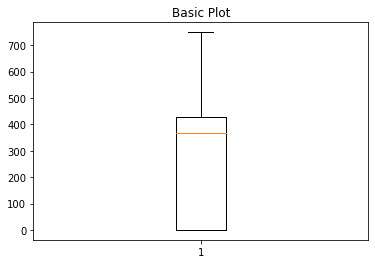

In [20]:
# Box plot
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(train_data['meter_reading'][train_data['building_id']==8])

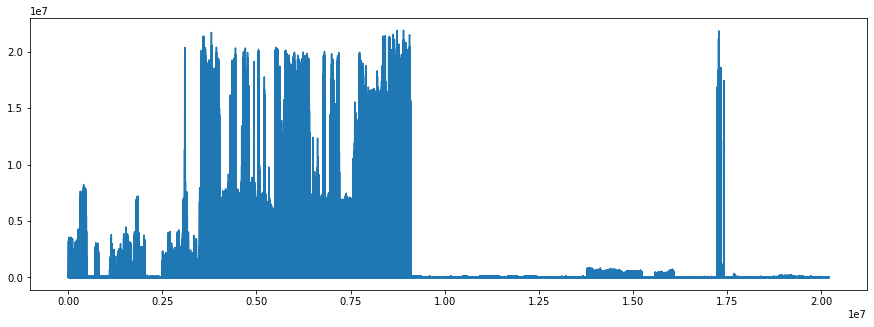

In [18]:
# There are some outlier for meter_reading around 1.75*10^7
plt.figure(figsize = (15,5))
train_data['meter_reading'].plot()

In [25]:
# All outlier of meter_reading of building_id is 1099
train_data[train_data['meter_reading']>1.75*(10**7)]

,building_id,meter,timestamp,meter_reading
3094775,1099,2,2016-02-27 19:00:00,19555200.0
3096856,1099,2,2016-02-27 20:00:00,20392200.0
3098934,1099,2,2016-02-27 21:00:00,20154200.0
3101013,1099,2,2016-02-27 22:00:00,19638600.0
3103092,1099,2,2016-02-27 23:00:00,19878400.0
...,...,...,...,...
17295867,1099,2,2016-11-09 18:00:00,18833400.0
17298228,1099,2,2016-11-09 19:00:00,17846500.0
17324218,1099,2,2016-11-10 06:00:00,17502600.0
17333669,1099,2,2016-11-10 10:00:00,17739400.0


In [32]:
train_data[train_data['building_id']==1099][20:50]

,building_id,meter,timestamp,meter_reading
24487,1099,0,2016-01-01 10:00:00,303.071
24488,1099,2,2016-01-01 10:00:00,3341210.000
26786,1099,0,2016-01-01 11:00:00,301.247
26787,1099,2,2016-01-01 11:00:00,2695780.000
29082,1099,0,2016-01-01 12:00:00,301.529
29083,1099,2,2016-01-01 12:00:00,2608420.000
31380,1099,0,2016-01-01 13:00:00,312.658
31381,1099,2,2016-01-01 13:00:00,2583650.000
33677,1099,0,2016-01-01 14:00:00,313.171
33678,1099,2,2016-01-01 14:00:00,2670430.000


In [40]:
# Examine missing value
# Half of data for cloud_coverage are the missing in train_weather and test_weather.
# Most of data are missing in floor_count and half of data are missing in year_built in building_data.
nullProp_train = train_data.isnull().sum()/len(train_data)
nullProp_trnw = train_weather.isnull().sum()/len(train_weather)
nullProp_tesw = test_weather.isnull().sum()/len(test_weather)
nullProp_bd = building_data.isnull().sum()/len(building_data)
print(nullProp_train)
print('-----------------------')
print(nullProp_trnw)
print('-----------------------')
print(nullProp_tesw)
print('-----------------------')
print(nullProp_bd)

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64
-----------------------
site_id               0.000000
timestamp             0.000000
air_temperature       0.000393
cloud_coverage        0.494895
dew_temperature       0.000808
precip_depth_1_hr     0.359791
sea_level_pressure    0.075966
wind_direction        0.044844
wind_speed            0.002175
dtype: float64
-----------------------
site_id               0.000000
timestamp             0.000000
air_temperature       0.000375
cloud_coverage        0.506588
dew_temperature       0.001179
precip_depth_1_hr     0.344781
sea_level_pressure    0.076702
wind_direction        0.044618
wind_speed            0.001659
dtype: float64
-----------------------
site_id        0.000000
building_id    0.000000
primary_use    0.000000
square_feet    0.000000
year_built     0.534161
floor_count    0.755003
dtype: float64


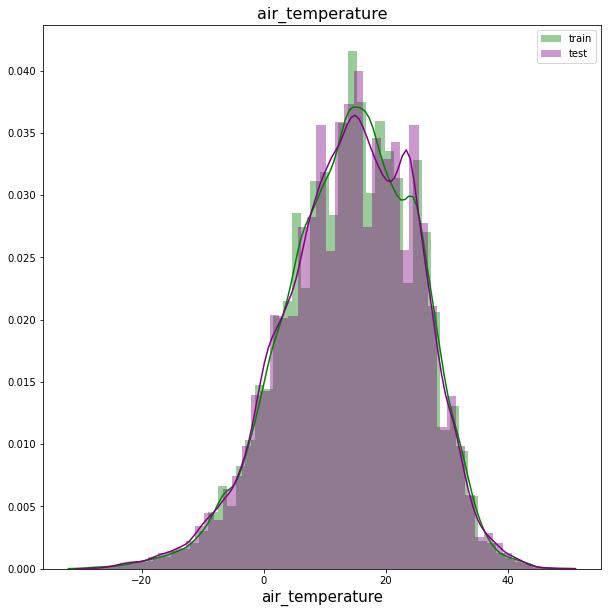

In [43]:
# Check the distribution of data in train_weather and test_weather
def plot_dist_col(column):
    '''plot dist curves for train and test weather data for the given column name'''
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(train_weather[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(test_weather[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()
plot_dist_col('air_temperature')

<Figure size 432x288 with 0 Axes>

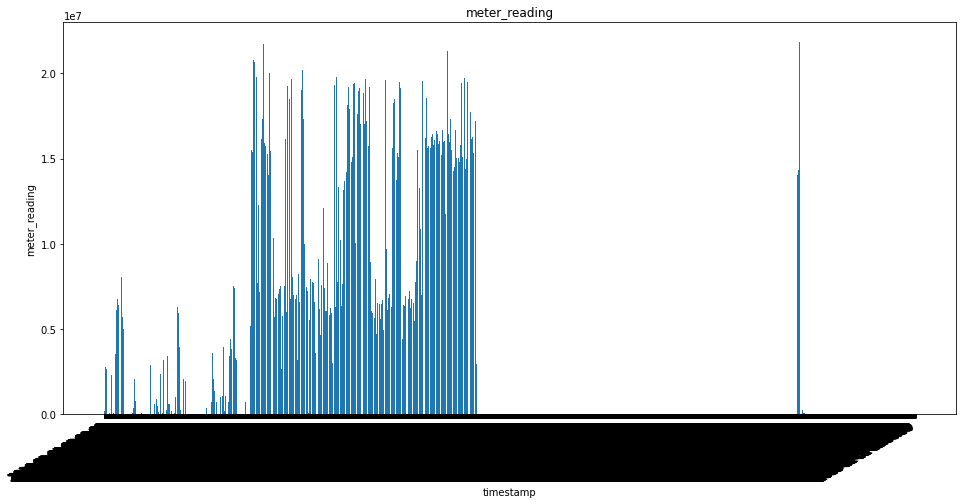

In [105]:
# Because there are some outliers for building_id 1099, I check the distribution of meter_reading.

fig = plt.figure()
ts = train_data[train_data['building_id']==1099].groupby(['timestamp'])['meter_reading'].sum()
ts.astype('float')

plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.bar(ts.index, ts)
plt.gcf().autofmt_xdate()
plt.show()

In [87]:
# Drop outilers from building_id == 1099
train_data = train_data.drop(train_data[train_data.building_id==1099].index)

In [104]:
# The different of temperature is huge in a year, so I'm NOT using average to fill NaN.
# fill NaN with data of closer time

In [5]:
# Use previous data to fill in nan data, because temperature is the time series data (train&test )
for i in range(0,len(train_weather)):
    if train_weather.isnull()['air_temperature'][i]== True:
        train_weather.loc[i,'air_temperature']= train_weather.loc[i-1,'air_temperature']

In [6]:
# fill in nan data of dew_temperature(train&test)
for i in range(0,len(test_weather)):
    if test_weather.isnull()['dew_temperature'][i]== True:
        test_weather.loc[i,'dew_temperature']= test_weather.loc[i-1,'dew_temperature']

In [7]:
# Drop cloud_coverage, wind_direction, from train_weather and test_weather
train_weather = train_weather.drop(['cloud_coverage', 'wind_direction'], axis=1)
test_weather = test_weather.drop(['cloud_coverage', 'wind_direction'], axis=1)

In [27]:
# Gererate new future from precip_depth_1_hr
for i in range(0,len(train_weather)):
    if np.isnan(train_weather.loc[i,'precip_depth_1_hr']) == True:
        train_weather.loc[i,'precip_depth_m']=1
    else:
        train_weather.loc[i,'precip_depth_m']=0

In [28]:
#train_weather['precip_depth_1_hr'].min()
# min of precip_depth_1_hr is -1
test_weather['precip_depth_1_hr']=test_weather['precip_depth_1_hr'].fillna(0)

In [37]:
# Check the mean of wind_speed in different site_id and fill it in na
for i in range(0,16):
    k=train_weather[train_weather.site_id==i]['wind_speed'].mean()
    train_weather.loc[train_weather.site_id==i, 'wind_speed'] = train_weather.loc[train_weather.site_id==i, 'wind_speed'].fillna(k)

In [22]:
# Fill nan data in sea_leavel_pressure by the last value
for i in range(0,len(train_weather)):
    if np.isnan(train_weather.loc[i, 'sea_level_pressure'])== True:
        train_weather.loc[i,'sea_level_pressure']= train_weather.loc[i-1,'sea_level_pressure']

In [21]:
# Generate new future 'diff_temp' that is air_temp - dew_temp
for i in range(0,len(train_weather)):
    train_weather.loc[i,'diff_temp'] = test_weather.loc[i,'air_temperature'] - test_weather.loc[i,'dew_temperature']

In [50]:
# check data is nan
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int64  
 1   timestamp           277243 non-null  object 
 2   air_temperature     277243 non-null  float64
 3   dew_temperature     277243 non-null  float64
 4   precip_depth_1_hr   277243 non-null  float64
 5   sea_level_pressure  277243 non-null  float64
 6   precip_depth_m      277243 non-null  float64
 7   diff_temp           277243 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 16.9+ MB


In [43]:
combine = [train_weather, test_weather]

In [44]:
# transform air_temp to category 
for dataset in combine:
    dataset.loc[dataset['air_temperature'] <= 0, 'air_temperature'] = 0
    dataset.loc[(dataset['air_temperature'] > 0) & (dataset['air_temperature'] <= 10), 'air_temperature'] = 1
    dataset.loc[(dataset['air_temperature'] > 10) & (dataset['air_temperature'] <= 20), 'air_temperature'] = 2
    dataset.loc[(dataset['air_temperature'] > 20) & (dataset['air_temperature'] <= 30), 'air_temperature'] = 3
    dataset.loc[dataset['air_temperature'] > 30, 'air_temperature'] = 4

In [45]:
# transform dew_temp to category 
for dataset in combine:
    dataset.loc[dataset['dew_temperature'] <= 0, 'dew_temperature'] = 0
    dataset.loc[(dataset['dew_temperature'] > 0) & (dataset['dew_temperature'] <= 10), 'dew_temperature'] = 1
    dataset.loc[(dataset['dew_temperature'] > 10) & (dataset['dew_temperature'] <= 20), 'dew_temperature'] = 2
    dataset.loc[dataset['dew_temperature'] > 20, 'dew_temperature'] = 3

In [46]:
# transform precip_depth_1_hr to category 
for dataset in combine:
    dataset.loc[dataset['precip_depth_1_hr'] ==-1, 'precip_depth_1_hr'] = 0
    dataset.loc[(dataset['precip_depth_1_hr'] == 0), 'precip_depth_1_hr'] = 1
    dataset.loc[dataset['precip_depth_1_hr'] > 0, 'precip_depth_1_hr'] = 2

In [207]:
# transform wind_speed to category 
for dataset in combine:
    dataset.loc[dataset['wind_speed'] <= 0, 'wind_speed'] = 0
    dataset.loc[(dataset['wind_speed'] > 0) & (dataset['wind_speed'] <= 2), 'wind_speed'] = 1
    dataset.loc[(dataset['wind_speed'] > 2) & (dataset['wind_speed'] <= 3), 'wind_speed'] = 2
    dataset.loc[(dataset['wind_speed'] > 3) & (dataset['wind_speed'] <= 5), 'wind_speed'] = 3
    dataset.loc[dataset['wind_speed'] > 5, 'wind_speed'] = 4

In [58]:
# Reduce memory
for dataset in combine:
    dataset['site_id'] = dataset['site_id'].astype('int16')
    dataset['air_temperature'] = dataset['air_temperature'].astype('float16')
    dataset['dew_temperature'] = dataset['dew_temperature'].astype('float16')
    dataset['precip_depth_1_hr'] = dataset['precip_depth_1_hr'].astype('float16')
    dataset['sea_level_pressure'] = dataset['sea_level_pressure'].astype('float16')
    dataset['diff_temp'] = dataset['diff_temp'].astype('float16')
    dataset['precip_depth_m'] = dataset['precip_depth_m'].astype('float16')

In [60]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             277243 non-null  int16  
 1   timestamp           277243 non-null  object 
 2   air_temperature     277243 non-null  float16
 3   dew_temperature     277243 non-null  float16
 4   precip_depth_1_hr   277243 non-null  float16
 5   sea_level_pressure  277243 non-null  float16
 6   precip_depth_m      277243 non-null  float16
 7   diff_temp           277243 non-null  float16
dtypes: float16(6), int16(1), object(1)
memory usage: 5.8+ MB


In [47]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [70]:
building_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   site_id       1449 non-null   int64  
 1   building_id   1449 non-null   int64  
 2   primary_use   1449 non-null   object 
 3   square_feet   1449 non-null   int64  
 4   year_built    1449 non-null   float64
 5   year_built_m  1449 non-null   float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [464]:
building_data.describe()

,site_id,building_id,square_feet,year_built,year_built_m
count,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000
mean,6.952381,724.000000,92111.776398,0.687371,0.534161
std,5.003432,418.434583,110769.950997,1.063384,0.499004
min,0.000000,0.000000,283.000000,0.000000,0.000000
25%,3.000000,362.000000,23012.000000,0.000000,0.000000
50%,5.000000,724.000000,57673.000000,0.000000,1.000000
75%,13.000000,1086.000000,115676.000000,1.000000,1.000000
max,15.000000,1448.000000,875000.000000,3.000000,1.000000


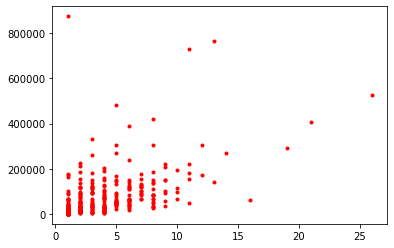

In [62]:
# Because there is no relation between floor_count and square_feet by plot and the missing value of floor_count
# is too much, drop floor_count variable
plt.plot(building_data['floor_count'],building_data['square_feet'],'r.')
building_data=building_data.drop(['floor_count'], axis=1)

In [63]:
building_data[['site_id','year_built']].groupby('site_id').describe()

year_built                                                            \
             count         mean        std     min      25%     50%      75%   
site_id                                                                        
0            105.0  1995.542857  14.500019  1968.0  1985.00  2001.0  2006.00   
1             40.0  1961.475000  31.795006  1900.0  1954.50  1960.0  1989.50   
2             94.0  1974.882979  25.745177  1907.0  1960.75  1973.5  1997.50   
3            132.0  1961.727273  35.870226  1900.0  1931.00  1961.5  2002.00   
4             89.0  1954.123596  32.119033  1903.0  1927.00  1955.0  1971.00   
5             88.0  1962.602273  22.283719  1919.0  1966.00  1976.0  1976.00   
6              0.0          NaN        NaN     NaN      NaN     NaN      NaN   
7             14.0  1958.500000  22.152444  1911.0  1952.75  1963.0  1969.75   
8              0.0          NaN        NaN     NaN      NaN     NaN      NaN   
9              0.0          NaN        NaN     NaN      NaN     NaN      NaN   
10             0.0          NaN        NaN     NaN      NaN     NaN      NaN   
11             0.0          NaN        NaN     NaN      NaN     NaN      NaN   
12             0.0          NaN        NaN     NaN      NaN     NaN      NaN   
13             0.0          NaN        NaN     NaN      NaN     NaN      NaN   
14             0.0          NaN        NaN     NaN      NaN     NaN      NaN   
15           113.0  1962.371681  30.262894  1902.0  1941.00  1964.0  1987.00   

                 
            max  
site_id          
0        2016.0  
1        2007.0  
2        2014.0  
3        2017.0  
4        2016.0  
5        2013.0  
6           NaN  
7        1995.0  
8           NaN  
9           NaN  
10          NaN  
11          NaN  
12          NaN  
13          NaN  
14          NaN  
15       2014.0

In [64]:
# Generate new indicator by missing data of year_built
# If year_built is NaN, year_built_m is 1. Otherwise is 0.
for i in range(0,len(building_data)):
    if building_data.loc[i,'year_built']>0:
        building_data.loc[i,'year_built_m']=0
    else:
        building_data.loc[i,'year_built_m']=1

In [65]:
# Using 1950 to replace missing data of year_built in building_data
for j in range(0,len(building_data)):
    if building_data['year_built'].isnull()[j]==True:
        building_data.loc[j,'year_built']=1950
    

In [66]:
# Transform year_built to categorical data
for k in range(0,len(building_data)):
    if building_data.loc[k,'year_built'] <= 1950:
        building_data.loc[k,'year_built'] = 0
    if 1950 < building_data.loc[k,'year_built'] <= 1970:
        building_data.loc[k,'year_built'] = 1
    if 1970 < building_data.loc[k,'year_built'] <= 1995:
        building_data.loc[k,'year_built'] = 2
    if building_data.loc[k,'year_built'] > 1995:
        building_data.loc[k,'year_built'] = 3

In [67]:
# Transform square_feet to categorical data
for k in range(0,len(building_data)):
    if building_data.loc[k,'square_feet'] <= 23012:
        building_data.loc[k,'square_feet'] = 0
    if 23012 < building_data.loc[k,'square_feet'] <= 57673:
        building_data.loc[k,'square_feet'] = 1
    if 57673 < building_data.loc[k,'square_feet'] <= 115676:
        building_data.loc[k,'square_feet'] = 2
    if building_data.loc[k,'square_feet'] > 115676:
        building_data.loc[k,'square_feet'] = 3

In [68]:
building_data['primary_use'].value_counts()

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64

In [69]:
# Transform primary_use to categorical data in building_data 
use_mapping = {"Education": 0,"Office": 1, "Entertainment/public assembly": 2, 
               "Public services": 3, "Lodging/residential": 4, "Other": 5, "Healthcare": 6, "Parking": 7,
               "Warehouse/storage": 7, "Manufacturing/industrial": 8, "Technology/science": 8,
               "Retail": 9, "Services": 9, "Food sales and service": 9, "Utility": 5, "Religious worship": 5}
for i in range(0,len(building_data)):
    building_data.loc[i,'primary_use'] = use_mapping[building_data.loc[i,'primary_use']]


In [90]:
# Merge train and building_data by key that is building_id
# Merge train and train_weather by key
train_data = pd.merge(train_data, building_data,on='building_id')
train_data = pd.merge(train_data, train_weather, on= ['site_id','timestamp'])

test_data = pd.merge(test_data, building_data,on='building_id')
test_data = pd.merge(test_data, test_weather, on= ['site_id','timestamp'], how='outer')

In [91]:
X_train = train_data.drop(['timestamp'], axis=1)
#,'sea_level_pressure','diff_temp','site_id','year_built_m'

Y_train = train_data["meter_reading"]
X_test  = test_data.drop(['timestamp'], axis=1)

In [92]:
del train_data, test_data, train_weather, test_weather, building_data
gc.collect()

2440

In [4]:
# Split data to 70% training and 30% testing 
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1= train_test_split( X_train, Y_train, test_size=0.3 )

# Using random forest to predict
random_forest = RandomForestRegressor(n_jobs=-1,n_estimators=100)
random_forest.fit(X_train1, Y_train1.astype('int'))
#Y_pred = random_forest.predict(X_test)
random_forest.score(X_test1, Y_test1)
acc_random_forest = round(random_forest.score(X_test1, Y_test1) * 100, 2)
acc_random_forest

100.0

In [73]:
Y_pred = random_forest.predict(X_test)
submission = pd.concat([X_test['row_id'],pd.Series(Y_pred)], axis=1, sort=False)
submission.columns=['row_id', 'meter_reading']

In [54]:
# Save model
filename = '/Users/a326/Documents/Gary/Energy prediction competition/model_rf.sav'
pickle.dump(random_forest, open(filename, 'wb'))

In [101]:
# Normalize
X_train['air_temperature'] = preprocessing.scale(X_train['air_temperature'])
X_train['dew_temperature'] = preprocessing.scale(X_train['dew_temperature'])
X_train['precip_depth_1_hr'] = preprocessing.scale(X_train['precip_depth_1_hr'])
X_train['sea_level_pressure'] = preprocessing.scale(X_train['sea_level_pressure'])
X_train['diff_temp'] = preprocessing.scale(X_train['diff_temp'])

Y_train = preprocessing.scale(Y_train)

X_test['air_temperature'] = preprocessing.scale(X_test['air_temperature'])
X_test['dew_temperature'] = preprocessing.scale(X_test['dew_temperature'])
X_test['precip_depth_1_hr'] = preprocessing.scale(X_test['precip_depth_1_hr'])
X_test['sea_level_pressure'] = preprocessing.scale(X_test['sea_level_pressure'])
X_test['diff_temp'] = preprocessing.scale(X_test['diff_temp'])

In [18]:
# Light gbm train
from sklearn.model_selection import train_test_split
X_train1, X_test1, Y_train1, Y_test1= train_test_split( X_train, Y_train, test_size=0.3 )

d_train = lgb.Dataset(X_train1, label= Y_train1)
param = {'num_leaves': 70, 'objective': 'regression_l1', 'metric': 'rmse', 'maxdepth': 20, 'boosting_type': 'gbdt',
        'learning_rate': 0.05}
num_round = 40
bst = lgb.train(param, d_train, num_round)


y_pred = bst.predict(X_test1)
#bst.save_model('/Users/a326/Documents/Gary/Energy prediction competition/model_lgbm0.txt')
y_pred_n = y_pred*(np.sqrt(Y_var))+Y_mean
Y_test1_n = Y_test1*(np.sqrt(Y_var))+Y_mean
score = ((1/len(y_pred_n))*np.sum((np.log(y_pred_n+1)-np.log(Y_test1_n+1))**2))**(1/2)
score

1.0261154102412722

In [19]:
# Light gbm test
submission = bst.predict(X_test)
submission = submission*(np.sqrt(Y_var))+Y_mean
submission = pd.concat([X_test['row_id'],pd.Series(submission)], axis=1, sort=False)
submission.columns=['row_id', 'meter_reading']